In [1]:
#open this notebook in environment by running following in terminal:
# source ~/miniconda/bin/activate
# jupyter notebook

In [2]:
!pip install nibabel
!pip install matplotlib
!pip install opencv-python

In [3]:
conda install --channel=conda-forge nilearn

Solving environment: done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [4]:
import numpy as np
import math
from random import sample
from glob import glob
import os

import json 
import nibabel as nib
import nibabel.processing 
from nibabel.processing import resample_to_output
import nilearn

import matplotlib.pyplot as plt
import PIL

from os import listdir
from os.path import isfile, join

import tensorflow as tf
import scipy
import sklearn
from sklearn.model_selection import train_test_split
from nilearn.image import concat_imgs, mean_img, resample_img

import tensorflow as tflow
from tensorflow.keras.layers import Flatten
from keras.layers.core import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

### Just some initial tests

In [5]:
#!ls './preprocessed-data/images'

In [6]:
#!ls './preprocessed-data/masks'

(64, 224, 224) <class 'numpy.ndarray'>


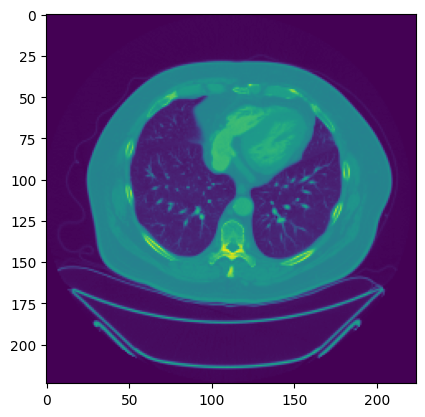

In [7]:
test_image=nib.load('./preprocessed-data/images/case_00004.nii.gz').get_fdata()

print(test_image.shape, type(test_image))
plt.imshow(test_image[2,:,:])

## Loading preprocessed images

In [8]:
def malignant_labels_to_dict(json_file_path):
    """Takes path to json file and stores malignant label for each 
    patient in a dictionary"""
    
    with open(json_file_path) as user_file:
      file_contents = user_file.read()

    meta_list = json.loads(file_contents)

    labels_dict = {}
    for case in meta_list:
        c_id = case['case_id']
        labels_dict[c_id] = case['malignant']
    
    return labels_dict

In [9]:
def generate_subsample_id_list(n_samples, pct_of_total_neg, dict_of_labels):
    subsample_id_list = []
    total_neg = len(dict_of_labels) - sum(dict_of_labels.values())
    n_neg = math.ceil(total_neg*(pct_of_total_neg/100))
    n_pos = n_samples - n_neg
    
    true_list = [k for k,v in dict_of_labels.items() if v == True]
    false_list = [k for k,v in dict_of_labels.items() if v == False]
    
    subsample_id_list.extend(false_list[:n_neg])
    subsample_id_list.extend(sample(true_list,n_pos))
                             
    print('Generated list of {0} case IDs of {1} positive and {2} negative labels'.format(
        len(subsample_id_list), n_neg, n_pos))
    
    return subsample_id_list

In [10]:
def processed_image_paths(rootdir, subfolder):
    """ Creates list of paths to images in each subfolder and corresponsing patient ID """
    
    folder_path = rootdir + subfolder
    paths_list = []
    for file in os.listdir(folder_path):
        paths_list.append(folder_path + '/' + file)
    
    #for file in os.listdir(rootdir_str):
    #    d = os.path.join(rootdir_str, file)
    #    if os.path.isdir(d):
    #        paths_list.append(d + general_filename)
            
    return paths_list

In [11]:
def load_nifti_img_and_mask_as_numpy(paths_list, subsample_list):
    """ Loads nifti images corresponding to paths lists in a dictionary 
    of case_id as keys and 3D numpy image arrays as values. Filters list by  """

    image_dict = {}

    for img_path in paths_list:
        case_id = img_path[-17:-7]
        if case_id in subsample_list:
            print('match on: ', case_id)
            ct_nii = nib.load(img_path).get_fdata()
            image_dict[case_id] = ct_nii
    
    return image_dict

In [12]:
#------------- Generate dictionary of case_id and binary malignant label --------
labels_dict = malignant_labels_to_dict('../kits21/kits21/data/kits.json')
print('Number of labels in labels_dict: ', len(labels_dict))

#------------- Sample n instances from labels_dict with all possible negative cases --------
subsample_list = generate_subsample_id_list(100, 100, labels_dict)

#------------- Generate list of paths to preprocessed images --------
rootdir = './preprocessed-data/'

image_paths_list = processed_image_paths(rootdir, 'images')
mask_paths_list = processed_image_paths(rootdir, 'masks')

print('Is image and mask path list the same lenght?: ', len(image_paths_list) == len(mask_paths_list))

#------------- Load images and masks filtered by subsample --------
image_dict = load_nifti_img_and_mask_as_numpy(image_paths_list, subsample_list)
mask_dict = load_nifti_img_and_mask_as_numpy(mask_paths_list, subsample_list)

print('Is image and mask dictionaries the same lenght?:', len(image_dict) == len(mask_dict))


Number of labels in labels_dict:  300
Generated list of 100 case IDs of 25 positive and 75 negative labels
Is image and mask path list the same lenght?:  True
match on:  case_00258
match on:  case_00092
match on:  case_00225
match on:  case_00229
match on:  case_00080
match on:  case_00045
match on:  case_00145
match on:  case_00138
match on:  case_00010
match on:  case_00061
match on:  case_00293
match on:  case_00147
match on:  case_00036
match on:  case_00155
match on:  case_00063
match on:  case_00012
match on:  case_00171
match on:  case_00211
match on:  case_00260
match on:  case_00082
match on:  case_00090
match on:  case_00116
match on:  case_00108
match on:  case_00075
match on:  case_00175
match on:  case_00004
match on:  case_00179
match on:  case_00079
match on:  case_00067
match on:  case_00020
match on:  case_00289
match on:  case_00043
match on:  case_00094
match on:  case_00240
match on:  case_00086
match on:  case_00098
match on:  case_00252
match on:  case_00264
match

In [ ]:
#print(labels_dict)
print(subsample_list)
#print(image_paths_list)
#print(image_dict['case_00246'])

## Creating traing, validation and test set

In [14]:
cases = subsample_list

labels =  [labels_dict[x] for x in cases]

print("Are cases and labels lists the same length?: ", len(cases) == len(labels))

Are cases and labels lists the same length?:  True


In [15]:
print(cases)
print(labels)

['case_00017', 'case_00019', 'case_00020', 'case_00031', 'case_00042', 'case_00043', 'case_00077', 'case_00082', 'case_00104', 'case_00116', 'case_00133', 'case_00137', 'case_00155', 'case_00156', 'case_00176', 'case_00188', 'case_00202', 'case_00205', 'case_00211', 'case_00225', 'case_00238', 'case_00253', 'case_00258', 'case_00275', 'case_00279', 'case_00247', 'case_00178', 'case_00171', 'case_00194', 'case_00252', 'case_00240', 'case_00061', 'case_00280', 'case_00286', 'case_00152', 'case_00105', 'case_00067', 'case_00040', 'case_00184', 'case_00229', 'case_00010', 'case_00260', 'case_00138', 'case_00267', 'case_00098', 'case_00264', 'case_00131', 'case_00145', 'case_00293', 'case_00269', 'case_00086', 'case_00080', 'case_00081', 'case_00045', 'case_00091', 'case_00170', 'case_00036', 'case_00079', 'case_00090', 'case_00125', 'case_00108', 'case_00234', 'case_00029', 'case_00063', 'case_00257', 'case_00232', 'case_00179', 'case_00263', 'case_00175', 'case_00151', 'case_00242', 'case

In [16]:
id_train, id_test_temp, labels_train, labels_test_temp = train_test_split(
    cases, labels, test_size=0.30, shuffle=True, stratify=labels)

id_val, id_test, labels_val, labels_test = train_test_split(
    id_test_temp, labels_test_temp, test_size=0.50, shuffle=True, random_state=42, stratify=labels_test_temp)

In [17]:
print(len(id_train))
print(id_train[0])

70
case_00138


In [20]:
image_dict['case_00150']

KeyError: 'case_00150'

In [19]:
def fill_set(x_set, y_set, image_dictionary, label_dictionary):
    x_list, y_list = [], []
    
    for idx, (x, y) in enumerate(zip(x_set, y_set)):    
        for img in image_dictionary[x]:
            x_list.append(img)
            y_list.append(label_dictionary[x])
    
    x_array, y_array = np.array(x_list), np.array(y_list).astype(int)
    x_array = np.array(tf.expand_dims(x_array, -1))
    y_array = np.asarray(y_train).astype('float32').reshape((-1,1))
    
    return x_array, y_array

x_train, y_train = fill_set(id_train, labels_train, image_dict, labels_dict)
#x_val, y_val = fill_set(id_val, labels_val, images_dict_preprocessed, labels_dict)
#x_test, y_test = fill_set(id_test, labels_test, images_dict_preprocessed, labels_dict)


print(x_train[0].shape, y_train[0])
print(len(x_train) == len(y_train))

KeyError: 'case_00150'

In [ ]:
print('x_train:', type(x_train), x_train.shape)
print('y_train:', type(y_train), y_train.shape)

In [ ]:
plt.imshow(x_train[0])

In [ ]:
os.listdir('./preprocessed-data/images')